# GAN Latent Vocabulary Demo

<figure>
<img src='https://visualvocab.csail.mit.edu/img/vcv_grid.gif' />
<figcaption>Two example primitive visual concepts learned from annotation data. <br>Experiments with human subjects show concepts generalize and compose.</figcaption>
</figure>

In this demo we will interact with a pretrained GAN (BigGAN-places) using a vocabulary of visual concepts. You can either load the vocabulary used in the paper, or generate new layer-selective directions and distill a vocabulary of visual concepts using your own corpus of annotations. 

See our [project page](https://visualvocab.csail.mit.edu/) or [paper](https://https://arxiv.org/pdf/2110.04292.pdf) for more information about this approach!

# Fundamentals: 

For this demo, we use [BigGAN](https://arxiv.org/abs/1809.11096) trained on the [Places365 dataset](http://places2.csail.mit.edu/) as our image generator (if you want to experiment, you can try downloading BigGAN-Imagenet instead). 

Recall that GANs are trained using a pair of models – a generator G and a discriminator D – using an adversarial loss. G learns a mapping from a random noise vector, z, to an image. D is a classifier that tries to distinguish whether an image is real, or generated by G. In addition to the noise vector z, the BigGAN-Places generator takes in a class vector y, which corresponds to the 365 scene categories in Places. A mapping of class identifiers to class labels can be found [here](https://github.com/schwettmann/homomorpher/blob/master/categories_places365.txt).

GANs, and BigGAN in particular, take a lot of time and compute to train properly. For our purposes, we want to uncover concepts within BigGAN latent space. Therefore, we will use a pretrained model and treat those weights as fixed. The following section sets up the prerequisites to build the BigGAN generator and load pretrained weights.

In [ ]:
!git clone https://github.com/schwettmann/pretorched-x.git  # pretrained BigGAN lives here

Cloning into 'pretorched-x'...
remote: Enumerating objects: 1489, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 1489 (delta 4), reused 0 (delta 0), pack-reused 1478
Receiving objects: 100% (1489/1489), 20.96 MiB | 24.41 MiB/s, done.
Resolving deltas: 100% (936/936), done.


In [ ]:
cd /content/pretorched-x

/content/pretorched-x


In [ ]:
import functools

import torch
from pretorched import gans
from pretorched.gans import BigGAN, biggan, utils
from pretorched import visualizers as vutils   

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [ ]:
res = 256
batch_size = 1 
pretrained = 'places365'   
n_classes = {'places365': 365, 'imagenet': 1000}.get(pretrained)
class_idx = 205   # Class within Places 

G = BigGAN(resolution=res, pretrained=pretrained, load_ema=True).to(device)


g = functools.partial(G, embed=True)
z, _ = utils.prepare_z_y(batch_size, G.dim_z, n_classes, device=device, z_var=0.5)
y = torch.randint(G.n_classes, (batch_size,), device=device)
y = class_idx * torch.ones(batch_size, device=device).long()

with torch.no_grad():
    G_z = utils.elastic_gan(g, z, y)  # Allows for batches larger than what fits in memory.  

Downloading: "http://pretorched-x.csail.mit.edu/gans/BigGAN/biggan256_G_ema_ch128_places365-6fb66feb.pth" to /root/.cache/torch/hub/checkpoints/biggan256_G_ema_ch128_places365-6fb66feb.pth


  0%|          | 0.00/551M [00:00<?, ?B/s]

Downloading: "http://pretorched-x.csail.mit.edu/gans/BigGAN/biggan256_state_dict_ch128_places365-7594847d.pth" to /root/.cache/torch/hub/checkpoints/biggan256_state_dict_ch128_places365-7594847d.pth


  0%|          | 0.00/4.27k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Now, try generating and visualizing a random samples(s) (of number `batchsize`) from Places category `class_idx`. Recall that a complete list of Places categories can be found [here](https://github.com/schwettmann/homomorpher/blob/master/categories_places365.txt). 




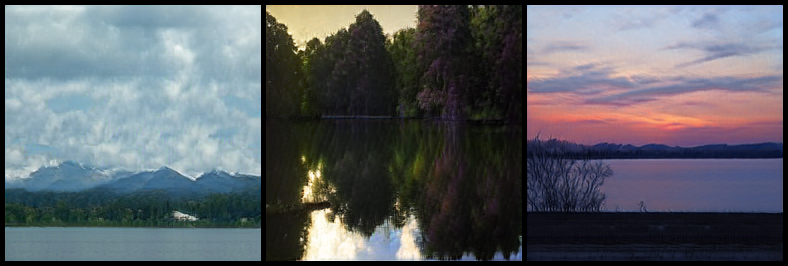

In [ ]:
batch_size = 3
class_idx = 205  # Try changing the image category here. 
y = class_idx * torch.ones(batch_size, device=device).long()
z, _ = utils.prepare_z_y(batch_size, G.dim_z, n_classes, device=device, z_var=0.5)
G_z_sample  = utils.elastic_gan(g, z, y)  
vutils.visualize_samples(G_z_sample)  # Lots of useful visualization tools are contained in vutils

# Loading the *bag-of-directions* model

You can load different precomputed vocabularies by changing `dataset_name` below to one of the following: 



> `'distilled_all'`  concepts learned across all classes <br>
> `'distilled_cottage'` concepts learned in the `cottage` class <br>
> `'distilled_kitchen'` concepts learned in the `kitchen` class <br>
> `'distilled_lake'` concepts learned in the `lake` class <br>
> `'distilled_medina'` concepts learned in the `medina` class<br>

In [ ]:
dataset_name='distilled_cottage'       # Experiment with different datasets by changing dataset_name

In [ ]:
import pandas as pd

In [ ]:
!git clone https://github.com/schwettmann/visual-vocab

Cloning into 'visual-vocab'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 152 (delta 51), reused 89 (delta 15), pack-reused 0
Receiving objects: 100% (152/152), 122.00 KiB | 8.71 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [ ]:
cd visual-vocab

/content/pretorched-x/visual-vocab


In [ ]:
from visualvocab import datasets
dataset = datasets.load(dataset_name)

  0%|          | 0/229354 [00:00<?, ?it/s]

Extracting /tmp/tmp0c51v7ry/distilled_cottage.zip to /content/pretorched-x/visual-vocab/data/distilled_cottage


In [ ]:
concepts_path = F"data/{dataset_name}/annotations.csv"  #if needed, change to wherever the datasets submodule unzips your dataset.
concepts = pd.read_csv(concepts_path,  encoding='utf-8')

directions_path = F"data/{dataset_name}/ds.pth"
directions = torch.load(directions_path,map_location=torch.device(device))  #directions will be size [#concepts, 119]


In [ ]:
concepts   #take a look at the frequency-sorted list of concepts present in G for this image class. 

,d_id,annotation
0,0,house
1,1,tree
2,2,color
3,3,sky
4,4,building
...,...,...
503,503,sparse
504,504,number
505,505,extends
506,506,becoming


## Visualizing Concepts

Now we can add or subtract any concept from an image $G(\mathbf{z})$ by adding (or subtacting) its corresponding direction $\mathbf{d}$ to input vector $\mathbf{z}$. Then we pass the modified noise vector through $G$ to visualize the concept: $G(\mathbf{z}+\mathbf{d})$. We can change how much of a concept we add (or subtract) by multiplying $\mathbf{d}$ by scaling factor $\alpha$:  $G(\mathbf{z}+\alpha\mathbf{d})$ Try experimenting with different values of $\alpha$. 

In [ ]:
# Define some useful functions 

def interp(x0, x1, num_midpoints):
  lerp = torch.linspace(0, 1.0, num_midpoints + 2, device='cuda').to(x0.dtype)
  p2 = lerp.size()
  p1 = lerp.view(1,-1,1).size()
  return ((x0 * (1 - lerp.view(1, -1, 1))) + (x1 * lerp.view(1, -1, 1)))


In [ ]:
def visualize_concept(concept_index, alpha, class_idx, z, num_midpoints): 

   print('concept:', concepts.iloc[concept_index,1])
   dir =  directions[concept_index]           # corresponding direction
   z_mod = z+ alpha*(dir/torch.norm(dir))     # modify z with concept
   z_seq = interp(z,z_mod,num_midpoints)      # generate sequence of z's 

   batch_size = num_midpoints + 2
   y = class_idx * torch.ones(batch_size, device='cuda').long()   # class vector
   G_z = utils.elastic_gan(g, torch.squeeze(z_seq), y)            # pass modified z's through G
   vutils.visualize_samples(G_z, nrow=batch_size)                 # visualize


Choose and visualize concepts: 

concept: tree


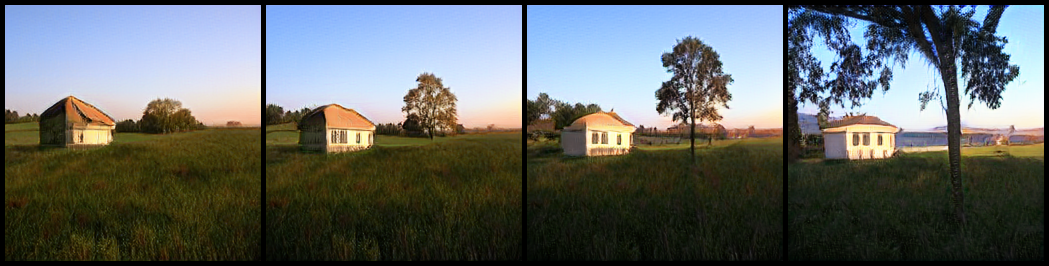

In [ ]:
z, _ = utils.prepare_z_y(1, G.dim_z, n_classes, device=device, z_var=0.5)   # generate a random z 
concept_index = 1    # you can change this index to experiment with different concepts. Concepts per category can be found in the project repo. 
alpha = 6            # scaling factor, can be positive or negative. |alpha| <10 works best. 
class_idx = 107      # cottage, change for other classes
num_midpoints = 2    # how many steps in the interpolation do you want to see? 

visualize_concept(concept_index, alpha, class_idx, z, num_midpoints)

# Learning your own model

Up to this point, we have been loading concepts and directions that reproduce results from the paper. You may want to try implementing the method for yourself, which involves: 


1.   Generating your own **layer-selective directions** 
2.   **Annotating** the LSDs (manually or automatically)
3.   **Disentangling** directions associated with individual concepts 

(1) Our method for disentangling individual concept directions (see [paper](https://https://arxiv.org/abs/2110.04292) Section 3.3) works with any corpus of annotated directions. For best results (a diverse vocabulary with high agreement across observers), we suggest using our method to generate layer-selective directions (LSDs) for annotation. Code for generating LSDs, which does require optimization, is below. 

(3) Direction annotations can be read in as a .csv file. You will then need to disentangle new directions associated with individual concepts. We suggest preprocessing and lemmatizing before disentangling concepts: we used the [NLTK lemmatizer](https://www.nltk.org/_modules/nltk/stem/wordnet.html) and `pyspellchecker`. Concept disentanglement can be done analytically with just a matrix $D$ of annotated directions, and a word matrix $W$ (where rows $i$ correspond to annotations, and columns $j$ correspond to individual words - $W_{i,j} = 1$  if word $j$ appears in direction annotation $i$, `else` $W_{i,j} = 0$). We formulate the learning of a visual concept vocabulary (of concept embeddings in $E$) as a regularized linear regression of the form: <br><center> $arg\,min_{\mathbf{E}} \left \| \mathbf{WE} - \mathbf{D} \right \|_F^2 + \lambda\left \| \mathbf{E} \right \|_F^2 $</center><br> 

Here we can solve analytically for E:  <br><center>$\mathbf{E} = (\mathbf{W}^\top\mathbf{W} + \lambda \mathbf{I} )^{-1}\mathbf{W}^\top\mathbf{D}  $</center><br> 

(where $I$ is the identity matrix with the same size as $\mathbf{W}^\top\mathbf{W}$). The hyperparameter $\lambda$ determines the balance between the L2 loss and the regularization of $E$. Try experimenting with values of $\lambda$ up to 100 to see what is most successful. 







---



## Generating LSDs: 

Define some useful functions: 

In [ ]:
def layer_regularizer_l1(zd, z,lay):
    #pull layer activations 
    zd_activations = G.forward(zd, y,embed=True, layer=lay)
    zd_activations_reshaped = zd_activations.view(zd_activations.size(0),-1) 
    z_activations = G.forward(z, y,embed=True, layer=lay)
    z_activations_reshaped = z_activations.view(z_activations.size(0),-1) 
    return (zd_activations_reshaped - z_activations_reshaped).abs().sum()  

In [ ]:
def layer_regularizer_L2(zd, z,lay):
    #pull layer activations 
    zd_activations = G.forward(zd, y,embed=True, layer=lay)
    zd_activations_reshaped = zd_activations.view(zd_activations.size(0),-1) 
    z_activations = G.forward(z, y,embed=True, layer=lay)
    z_activations_reshaped = z_activations.view(z_activations.size(0),-1) 
    a = torch.abs(zd_activations_reshaped - z_activations_reshaped)
    return a.pow(2).mean()  

In [ ]:
def choose_orthog_z(mat):
  if mat.nelement() ==0:   # if empty 
    d, _ = utils.prepare_z_y(batch_size, G.dim_z, n_classes, device=device, z_var=0.5)  # start with a random d
    basis_mat = []
    return d, basis_mat    # generate any starting z, don't need to be orthog. 
  basis_mat = torch.qr(mat.t())[0].t() 
  some_z = torch.randn(119).cuda()
  z_in_subspace = torch.mm(basis_mat.t(), torch.mm(basis_mat, some_z[:,None]))[:,0]
  d = some_z - z_in_subspace  # make starting d orthogonal to subspace 
  return d, basis_mat

## Train Loop

Here we perform the training operation to learn our desired LSDs. 

In [ ]:
def optimize_lsds(z, num_dirs_per_layer, num_samples, start_layer, end_layer, visualize, learning_rate, new_class, savedirs, savepath): 

  y = new_class * torch.ones(1, device=device).long()
  G_z  = utils.elastic_gan(g, z, y)
  print('Original z')
  vutils.visualize_samples(G_z)
  dnorm_mat = torch.tensor(()).cuda()  # init as empty

  for layer in range(start_layer,end_layer-1,-1):  

    dnorm_mat_layer = []                # collect LSDs per layer here 

    for j in range(num_dirs_per_layer): 
      d, basis_mat = choose_orthog_z(dnorm_mat)  # choose initial d orthogonal to all previously chosen d (just chooses random d if no d chosen yet) 
      d  = torch.nn.Parameter(d, requires_grad=True)
      optimizer = torch.optim.Adam([d], lr=learning_rate)

      with torch.enable_grad():         # optimization loop
        for step_num in (range(num_samples)): 
          optimizer.zero_grad()         # zero gradients 
          if layer == start_layer:      # no need to enforce orthogonality 
            dnorm = d/torch.norm(d)     # normalize d before adding to z
          else:                         # enforce orthogonality constraint 
            d_in_subspace = torch.mm(basis_mat.t(), torch.mm(basis_mat, d[:,None]))[:,0]
            d_orthog = d - d_in_subspace
            dnorm = d_orthog/torch.norm(d_orthog)
          zd= z+10*dnorm                # do a forward pass to get model outputs, alpha = 10 
          loss = 0.02 * layer_regularizer_L2(zd,z,layer)
          loss.backward                 # optimize loss
          optimizer.step()

      if layer == start_layer:
        dnorm = d/torch.norm(d)
      else: 
        d_in_subspace = torch.mm(basis_mat.t(), torch.mm(basis_mat, d[:,None]))[:,0]
        d_orthog = d - d_in_subspace
        dnorm = d_orthog/torch.norm(d_orthog)

      dnorm_mat_layer.append(dnorm)

      if visualize:                     # careful about memory if you are generating a lot 
        z_mod = z + 10*dnorm
        G_zmod  = utils.elastic_gan(g, z_mod, y)
        print("layer",layer,"direction",j)
        vutils.visualize_samples(G_zmod)

    dnorm_mat_layer = torch.stack(dnorm_mat_layer)
    dnorm_mat = torch.cat((dnorm_mat, dnorm_mat_layer),0)
    dnorm_mat = torch.squeeze(dnorm_mat)

  if savedirs: 
    path  = F"{savepath}/LSDs_L{start_layer}_{end_layer}" 
    torch.save(dnorm_mat,path)

  return dnorm_mat

This is a short example, taking only a few seconds to run, to make sure your code works if you are changing parameters. In practice, we want many more samples. To do that, increase `num_samples` (e.g. to 1000) but that will take longer.

Original z


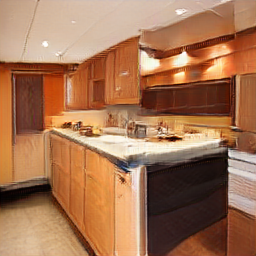

layer 2 direction 0


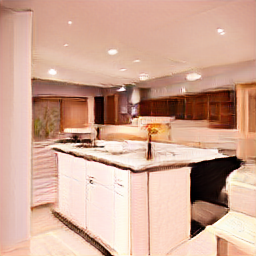

layer 2 direction 1


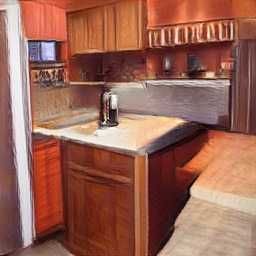

layer 2 direction 2


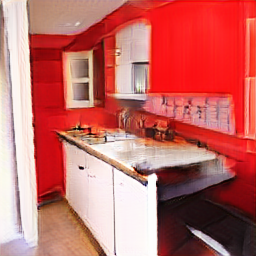

layer 2 direction 3


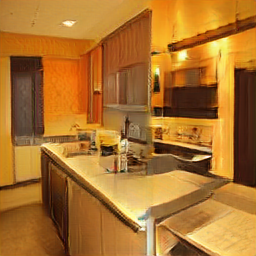

layer 1 direction 0


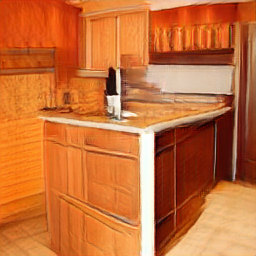

layer 1 direction 1


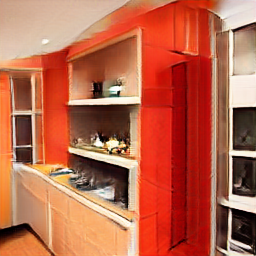

layer 1 direction 2


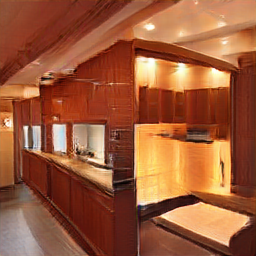

layer 1 direction 3


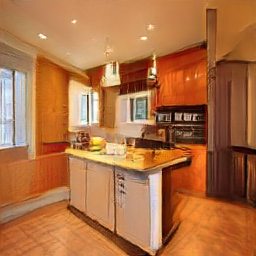

layer 0 direction 0


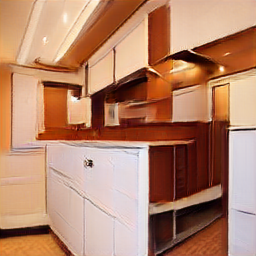

layer 0 direction 1


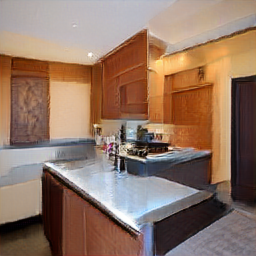

layer 0 direction 2


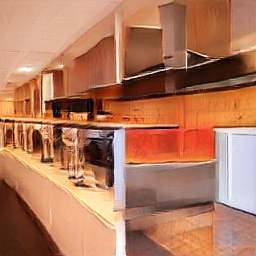

layer 0 direction 3


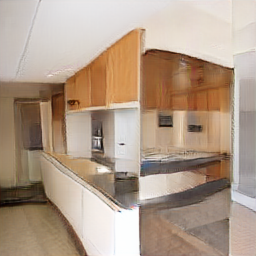

In [ ]:
# Training parameters 

batch_size = 1         # for generator, do not change this
new_class  = 203       # class you're working in (change)
learning_rate = 0.01   # you can also try changing this as well
num_dirs_per_layer = 4 # number of LSDs you want to generate per layer
num_samples = 10       # num samples for optimization. Training on 2000 samples should get you a desired result.
start_layer = 2        # higher numbers are closer to image output = more fine-grained features 
end_layer = 0          # leave end_layer 0 and you will calcualate LSDs for all layers before (&incl.) start layer. 
visualize = True       #print images of each generated direction after optimization?
savedirs = False       #save each LSD?
savepath = '/content/pretorched-x/examples/dirs/'    #set to your own path where you want to save the LSDs

# generate a single random z. To find directions for more than one z, stick this in a for loop
z, _ = utils.prepare_z_y(batch_size, G.dim_z, n_classes, device=device, z_var=0.5)   #generate a random z 

directions = optimize_lsds(z, num_dirs_per_layer, num_samples, start_layer, end_layer, visualize, learning_rate, new_class, savedirs, savepath)
